#### Steady State Kalman Filter Equations

> $\dot{P}(t) = AP(t) + P(t)A^{T} + GQG^{T} - P(t)H^{T}R^{-1}HP(t)$

> $\dot{\hat{x}}(t) = A\hat{x}(t) + Bu(t) + P(t)H^{T}R^{-1}[z(t) - H\hat{x}(t)]$
>> $K(t) = P(t)H^TR^{-1}$

> $\dot{e}(t) = \dot{x}(t)-\dot{\hat{x}} = (A-K(t)H)e(t) \ + Gw \\ \dot{P}_e = (A-K(t)H)P_e(A-K(t)H)^T + GQG^T$

Follow this link for complete explanation of what's being done here: 
https://www.notion.so/Steady-State-Kalman-Gain-and-Averaging-602bd1237b5044049e2e85d17af2b2f8

>$K = PH^TR^{-1}\\ where: \ \ 0 = AP + PA^{T} + GQG^{T} - PH^{T}R^{-1}HP\\ note: \ P = P(t=\infty)$


In [ ]:
# Explore the steady state covariance
import numpy as np
import control as ct
import sympy
from sympy import Matrix, MatrixSymbol, solve

# constants 
c = 2.99792458e8;
L5 = 1176.45e6;
lam5 = c/L5;

# clock noise information
CN0dBHz = -0
CN0 = 10**(CN0dBHz/10)

h0 = 1.5e-22
h0 = h0*20    # *20 w/ vibration
h_2 = 8.5e-32

Sf = h0/2*L5**2
Sg = 2*np.pi**2*h_2*L5**2

# noise terms for SS system
Q_elem = [Sf, Sg]
Q = sympy.diag(*Q_elem)
R = Matrix([[1/CN0]])

# dynamic and measurement model information
nq, _ = Q.shape
H = Matrix([[1,0]])
A = Matrix([[0,1],[0,0]])
G = sympy.eye(nq)

# we define the covariance in symbolic form 
n, m = A.shape
P = MatrixSymbol('P', n, m)

# define algebraic Riccati equation (ARE) that dictates steady state covariance
are = sympy.Eq(A*P + P*A.T + G*Q*G.T - P*H.T*R.inv()*H*P,0)
solution = solve(are, P)

def sympy_to_control_tf(tf_matrix):
    s = sympy.symbols('s')
    tf_sys = []

    for tf in tf_matrix:
        num, den = sympy.fraction(tf)
        num_coeffs = sympy.Poly(num, s).all_coeffs()
        den_coeffs = sympy.Poly(den, s).all_coeffs()

        tf_sys.append(ct.TransferFunction(num_coeffs, den_coeffs))

    return tf_sys

if not solution:
    print("No solution found. Exiting process.")
else: 
    # process the solution 
    print("Solution found. Continuing process.")
    # the solution to the ARE represents P(t=inf) 
    P_inf = solution
    print(solution)
    K_inf = P_inf*H.T*R.inv()
    
    # next, we can determine what the transfer functions for the system are :
    s = sympy.symbols('s')
    Omega = A - K_inf*H
    Tfs = (s*sympy.eye(n) - Omega).inv()

    # get control toolbox-compatable transfer functions 
    ct_Tfs = sympy_to_control_tf(Tfs)

In [ ]:
# Calculate the observability matrix
n = A.shape[0]  # Number of states
obs_matrices = [H * A**i for i in range(n)]
observability_matrix = Matrix.hstack(*obs_matrices)

# Check the rank of the observability matrix
observability_rank = observability_matrix.rank()

# Check observability
if observability_rank == n:
    print("The system is observable.")
else:
    print("The system is not observable.")

denominator poly: 
 Poly(1.52386960751108e-6*s**2 + 6.9484103635479e-8*s + 2.32217858069597e-12, s, domain='RR')
[-4.55637003e-02+0.j -3.34448168e-05+0.j]
(-3.34448167601996e-05+0j)
Time constant: -29899.99936821397
Transfer function: 
 
              1.524e-06 s
---------------------------------------
1.524e-06 s^2 + 6.948e-08 s + 2.322e-12

denominator poly: 
 Poly(1.52386960751108e-6*s**2 + 6.9484103635479e-8*s + 2.32217858069597e-12, s, domain='RR')
[-4.55637003e-02+0.j -3.34448168e-05+0.j]
(-3.34448167601996e-05+0j)
Time constant: -29899.99936821397
Transfer function: 
 
               1.524e-06
---------------------------------------
1.524e-06 s^2 + 6.948e-08 s + 2.322e-12

denominator poly: 
 Poly(1.0*s**2 + 0.0455971451185819*s + 1.52386960751108e-6, s, domain='RR')
[-4.55637003e-02+0.j -3.34448168e-05+0.j]
(-3.344481676019961e-05+0j)
Time constant: -29899.99936821396
Transfer function: 
 
        -1.524e-06
--------------------------
s^2 + 0.0456 s + 1.524e-06

denominator pol

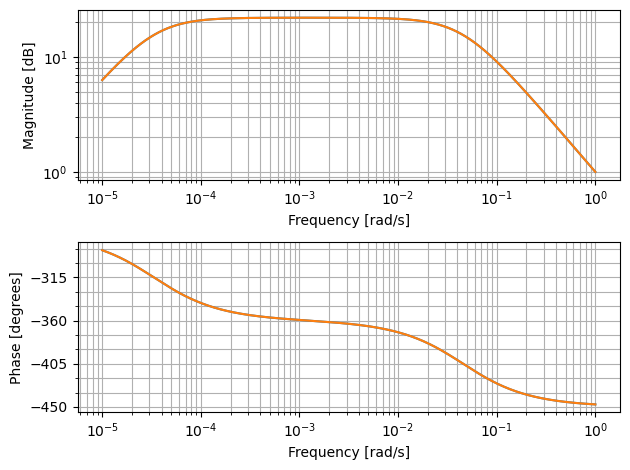

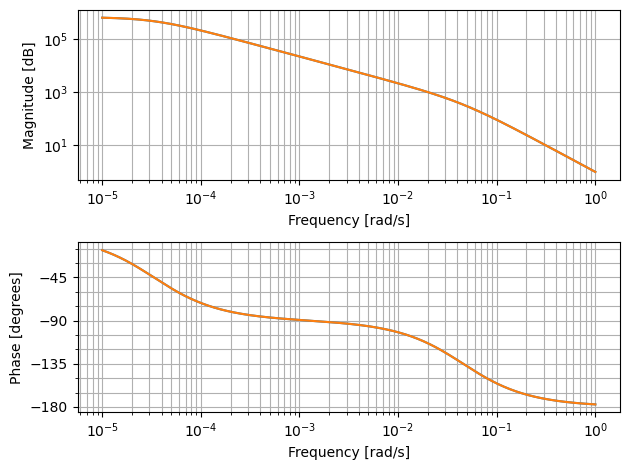

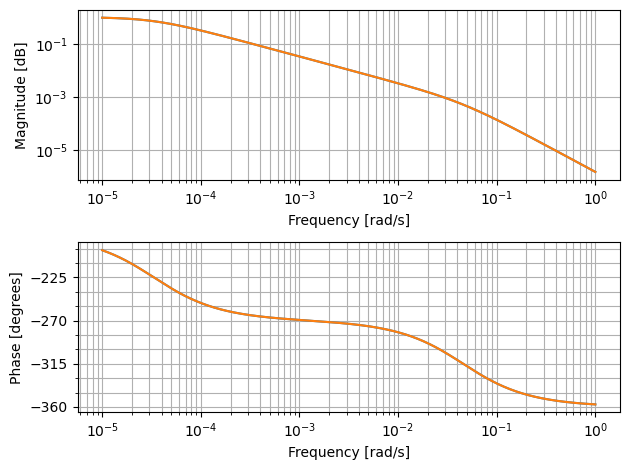

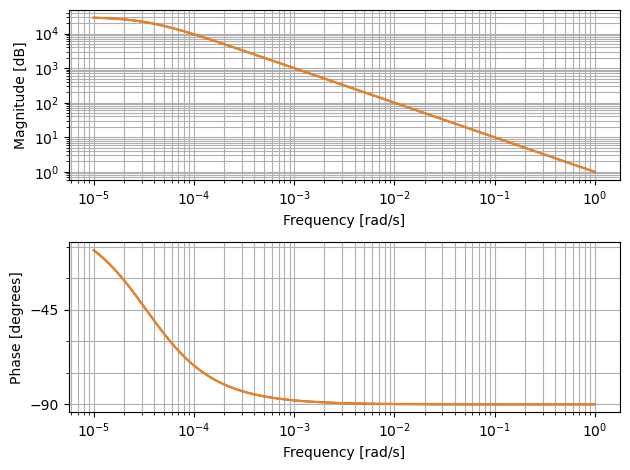

Steady-state Kalman gain:
[[4.55971451e-02]
 [1.52386961e-06]]


In [74]:
import numpy as np
import control as ct
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

# constants 
c = 2.99792458e8;
L5 = 1176.45e6;
lam5 = c/L5;

# clock noise information
CN0dBHz = -0
CN0 = 10**(CN0dBHz/10)

h0 = 1.5e-22
h0 = h0*20    # *20 w/ vibration
h_2 = 8.5e-32

Sf = h0/2*L5**2
Sg = 2*np.pi**2*h_2*L5**2

# Define system matrices
A = np.array([[0, 1], [0, 0]])  # State transition matrix
B = np.array([[0], [0]])  # Control input matrix
C = np.array([[1, 0]])  # Observation matrix
Q = np.array([[Sf, 0], [0, Sg]])  # Process noise covariance
R = np.array([[1/CN0]])  # Measurement noise covariance

# Compute steady-state covariance matrix
P = solve_continuous_are(A.T, C.T, Q, R)

# Compute steady-state Kalman gain
K_ss = np.dot(P, C.T) / R

s = sympy.symbols('s')
I = sympy.eye(A.shape[0])

# contruct the steady state transfer functions 
T_ss = (s * I - A + K_ss * C).inv()

# Create a list to store the control transfer functions and time constants
transfer_functions = []
time_constants = []

for row in T_ss: 
    # Extract the numerator and denominator of the transfer function
    numerator, denominator = sympy.fraction(row)

    # Cast numerator and denominator as polynomials
    numerator_poly = sympy.Poly(numerator, s)
    denominator_poly = sympy.Poly(denominator, s)

    print("denominator poly: \n",denominator_poly)

    # get coefficents of s in format usable for control systems library
    numerator_coeffs = numerator_poly.all_coeffs()
    denominator_coeffs = denominator_poly.all_coeffs()

    # Convert coefficients to lists for control systems library
    numerator_coeffs = [float(coeff) for coeff in numerator_coeffs]
    denominator_coeffs = [float(coeff) for coeff in denominator_coeffs]

    # Print the coefficients
    # print("Numerator coefficients:", numerator_coeffs)
    # print("Denominator coefficients:", denominator_coeffs)

    # make transfer funtions 
    tf = ct.TransferFunction(numerator_coeffs, denominator_coeffs)

    # Find the dominant pole
    poles = ct.pole(tf)
    print(poles)
    dominant_pole = np.max(poles)
    print(dominant_pole)

    # Calculate the time constant
    time_constant = 1 / np.real(dominant_pole)

    # Print the time constant
    print("Time constant:", time_constant)

    # print transfer function to check correctness 
    print("Transfer function: \n", tf)

    # append for analysis
    transfer_functions.append(tf)
    time_constants.append(time_constant)

# Create a new figure for each output channel
for i, tf in enumerate(transfer_functions):
    plt.figure(i + 1)
    
    # Compute the magnitude, phase, and frequency
    mag, phase, omega = ct.bode_plot(tf)

    # Convert phase from radians to degrees
    phase_deg = np.degrees(phase)
    
    # Plot the magnitude response
    plt.subplot(2, 1, 1)
    plt.semilogx(omega, mag)
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True)
    
    # Plot the phase response
    plt.subplot(2, 1, 2)
    plt.semilogx(omega, phase_deg)
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Phase [degrees]')
    plt.grid(True)
    plt.tight_layout()

# Show the plots
plt.show()

print("Steady-state Kalman gain:")
print(K_ss)


Time constant: -29899.99936821397
Time constant: -29899.99936821397
Time constant: -29899.99936821396
Time constant: -29899.99936821396


C:\Users\logan\AppData\Local\Temp\ipykernel_18692\3580872384.py:57: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_plots, 2, 2 * i + 1)


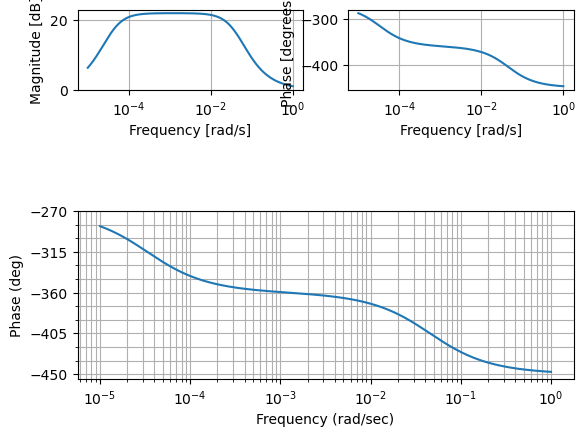

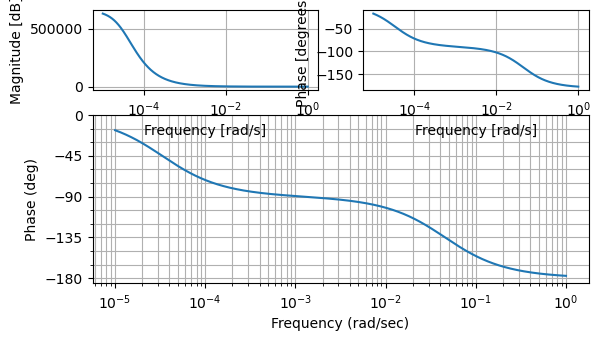

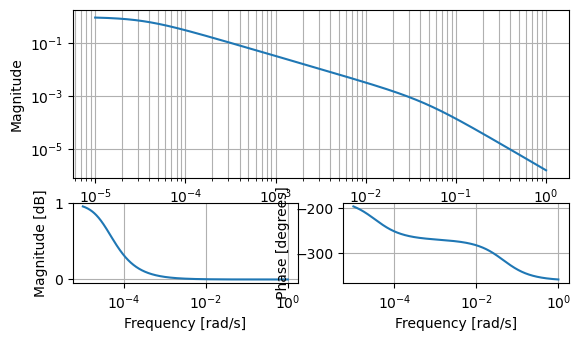

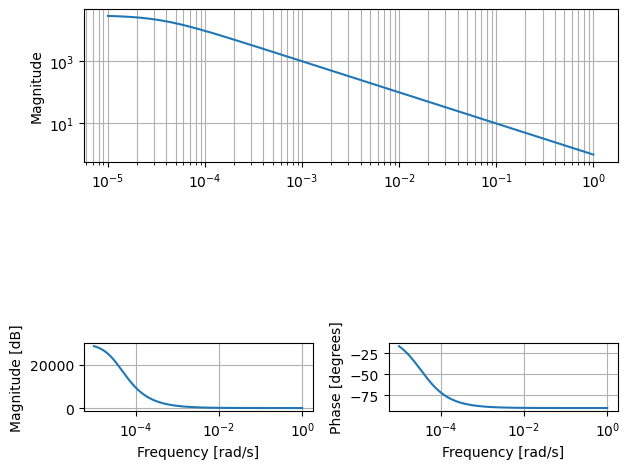

In [79]:
import numpy as np
import control as ct
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt

def ssResponse(T_ss):
    # Create a list to store the control transfer functions and time constants
    transfer_functions = []
    time_constants = []

    for row in T_ss:
        # Extract the numerator and denominator of the transfer function
        numerator, denominator = sympy.fraction(row)

        # Cast numerator and denominator as polynomials
        numerator_poly = sympy.Poly(numerator, s)
        denominator_poly = sympy.Poly(denominator, s)

        # get coefficients of s in format usable for control systems library
        numerator_coeffs = numerator_poly.all_coeffs()
        denominator_coeffs = denominator_poly.all_coeffs()

        # Convert coefficients to lists for control systems library
        numerator_coeffs = [float(coeff) for coeff in numerator_coeffs]
        denominator_coeffs = [float(coeff) for coeff in denominator_coeffs]

        # make transfer functions
        tf = ct.TransferFunction(numerator_coeffs, denominator_coeffs)

        # Find the dominant pole
        poles = ct.pole(tf)
        dominant_pole = np.max(poles)

        # Calculate the time constant
        time_constant = 1 / np.real(dominant_pole)

        # Print the time constant
        print("Time constant:", time_constant)

        # append for analysis
        transfer_functions.append(tf)
        time_constants.append(time_constant)

    num_plots = len(transfer_functions)

    # Create a new figure for each transfer function
    fig, axs = plt.subplots(num_plots, 2)

    for i, tf in enumerate(transfer_functions):
        # Compute the magnitude, phase, and frequency
        mag, phase, omega = ct.bode_plot(tf)

        # Convert phase from radians to degrees
        phase_deg = np.degrees(phase)

        # Plot the magnitude response
        axs[i, 0].semilogx(omega, mag)
        axs[i, 0].set_xlabel('Frequency [rad/s]')
        axs[i, 0].set_ylabel('Magnitude [dB]')
        axs[i, 0].grid(True)

        # Plot the phase response
        axs[i, 1].semilogx(omega, phase_deg)
        axs[i, 1].set_xlabel('Frequency [rad/s]')
        axs[i, 1].set_ylabel('Phase [degrees]')
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return plt, transfer_functions, time_constants

plots, tfs, taus = ssResponse(T_ss) 